# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


# The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`. The landmark images are a subset of the **Google Landmarks Dataset v2**.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler

from PIL import Image
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#### For accessing data in Google Colab ####

#from google.colab import drive
#drive.mount('/content/google')

#import zipfile
#zipfile.ZipFile('/content/google/MyDrive/Data/landmark_images.zip').extractall()

Mounted at /content/google


## Preprocessing

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [105]:
# Define transforms for the training data and testing data  

# image directory location:
data_dir = './landmark_images'

# set final target height H and width W for all images
H = 224
W = 224
# intermediate size values for train data augmentations
h1 = 248
w1 = 248
h0 = 272
w0 = 272

train_transforms = transforms.Compose([ #transforms.Pad((0,0,200,0), padding_mode='reflect'),
                                        transforms.Resize((h0, w0)),
                                        #transforms.RandomHorizontalFlip(),
                                        transforms.RandomResizedCrop((H,W)),
                                        #transforms.RandomRotation(10, expand=True, fill=0),
                                        #transforms.CenterCrop((H, W)),
                                        transforms.ToTensor()]) 

test_transforms = transforms.Compose([ transforms.Resize((H, W)),
                                       transforms.ToTensor()])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

### Toggle taking validation data from either train_data or test_data
#data = train_data
data = test_data

# Randomly separate out validation data
datasize = len(data) 
indices = list(range(datasize))
np.random.shuffle(indices)
split = int(datasize//6)
data_idx, valid_idx = indices[split:], indices[:split]

# cumbersome implementation of choice for which data set to use
if data is train_data:
    train_idx = data_idx
else:
    train_idx = list(range(len(train_data)))

# define samplers for obtaining training and validation batches    
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = RandomSampler(test_data)

num_workers=2 # not sure what difference this may make

## Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

## low batch sizes to avoid crashing the GPU!
## and values that maximize size of last set, eg. #train_sampler % 19 = 18
trainloader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=19,
                                          sampler=train_sampler,
                                          num_workers=num_workers)

validloader = torch.utils.data.DataLoader(data, 
                                          batch_size=19,
                                          sampler=valid_sampler,
                                          num_workers=num_workers)

testloader = torch.utils.data.DataLoader(test_data, 
                                         batch_size=10,
                                         sampler=test_sampler,
                                         num_workers=num_workers)

loaders = {'train': trainloader, 'valid': validloader, 'test': testloader}
loaders_scratch = loaders
loaders_transfer = loaders

## Define class dicts
classes = test_data.classes
classes.sort()
class2num = {c[3:]:int(c[:2]) for c in classes}
num2class = {int(c[:2]):c[3:] for c in classes}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

__Answer:__ 

I experimented with a variety of shapes and sizes and, for the training-set images, with different augmentations such as random rotation, horizontal flipping, random cropping, etc.  The first thing I found out is that if the images are too large that will make the GPU prone to crash from lack of memory!  (And it took me a while to figure out what was causing that. I also decreased the batch-size, and the GPU is not crashing anymore).  

The second thing I realized was that all the augmentations were being applied at run-time to each single image, which slowed down the training process considerably. I was also concerned that too much distortion might make accurate categorization more difficult. I suppose there is a certain limit to how much randomicity can be applied before all the images look essentially the same, but before that at some point a maximization of generality without too much loss of accuracy.  I did not find that point though, and in the end I kept only the augmentations that seemed to take the least time to process.

The specific size of 224x224 I chose because that is the expected input size for most of the pretrained models available from torchvision.  It could probably be lower than that but with all the other variables at play I decided to just keep to what works. That size doesn't seem to crash the GPU, so I left it at that!

I wanted to find a way to keep the 3:4 aspect ratio so as to minimize distortion for the apparently most-common 600x800 images. In the end I decided that the best way to minimize the distortion across *all* the different aspect ratios was to reduce every image down to a 1:1 "fair-and-square" aspect ratio.

The test images were not distorted beyond being resized.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

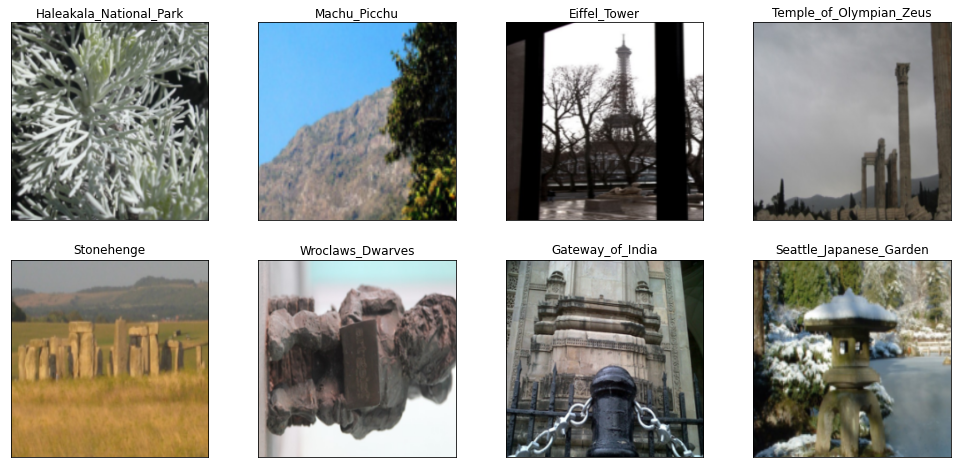

In [106]:
## visualize a batch of the train loader

#del train_data_iter
try:
    images, labels = train_data_iter.next()
except NameError:
    train_data_iter = iter(loaders_scratch['train'])
    images, labels = train_data_iter.next()

fig = plt.figure(figsize=(17,8),clear=True)
axes = fig.subplots(nrows=2, ncols=4, sharex=True, sharey=True)
axes = axes.flatten()
for i, im in enumerate(images[0:8]):
    ax = axes[i]
    title = num2class[labels[i].item()]
    ax.set_title(title)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    ax.imshow(np.transpose(im, (1,2,0)))

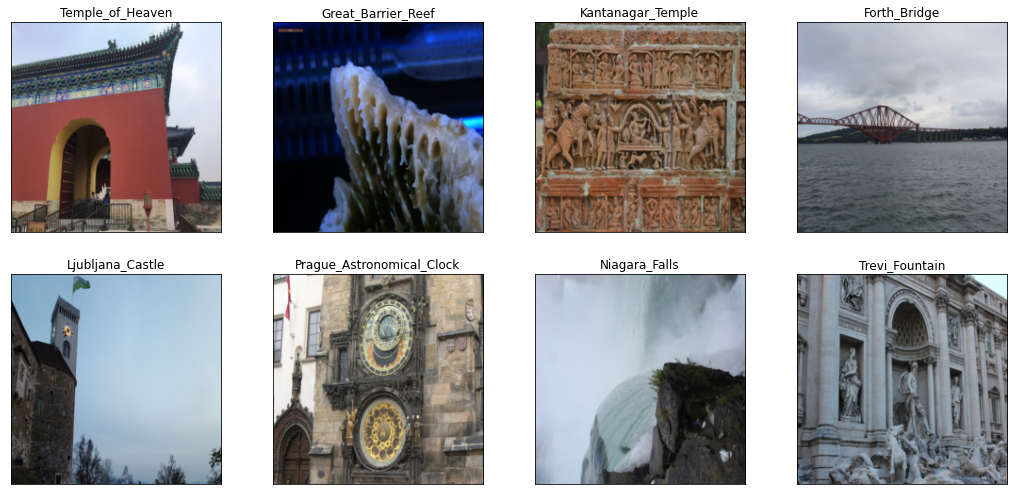

In [107]:
### Preview test images

#del test_data_iter
try:
    images, labels = test_data_iter.next()
except NameError:
    test_data_iter = iter(testloader)
    images, labels = test_data_iter.next()

labels = labels.tolist()

fig = plt.figure(figsize=(18,8.5))
axes = fig.subplots(nrows=2, ncols=4)
axes = axes.flatten()

idx = rd.randrange(images.shape[0]-8)
for i in range(idx,idx+8):
    img = np.transpose(images[i], (1,2,0))
    title = num2class[labels[i]]
    axes[i-idx].set_title(title)
    axes[i-idx].set_xticks([])
    axes[i-idx].set_yticks([])
    axes[i-idx].imshow(img)


<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [108]:
## select scratch loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model, lr=0.001):
    ## select and return an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [109]:
# Calculate a layer's output shape
def output_volume(w, f, s, p):
    ''' Calculate a convolutional layer's output size
    params:
    w = input volume (tuple)
    f = kernel size (tuple)
    s = stride (int)
    p = padding (int)
    '''
    x = (w[0] - f[0] + 2*p)/s + 1
    y = (w[1] - f[1] + 2*p)/s + 1
    return ( int(np.floor(x)), int(np.floor(y)) )

In [110]:
## model class "scratchNet"

# First calculate output volume of convolutional layers
out = output_volume((H,W),(3,3),1,1)
print("first in {} \t first out {}".format((H,W), out))
inn = out
out = output_volume(inn,(3,3),1,1)
print("second in {} \t second out {} >> pool12".format(inn,out))
inn = (out[0]//2, out[1]//2)
out = output_volume(inn,(3,3),1,1)
print("third in {} \t third out {}".format(inn,out))
inn = out
out = output_volume(inn,(3,3),1,1)
print("fourth in {} \t fourth out {} >> pool34".format(inn,out))
inn = (out[0]//2, out[1]//2)
out = output_volume(inn,(3,3),1,1)
print("fifth in {} \t fifth out {} >> pool5".format(inn,out))
inn = (out[0]//2, out[1]//2)
out = output_volume(inn,(3,3),1,1)
print("sixth in {} \t sixth out {} >> pool6".format(inn,out))
out = (out[0]//2, out[1]//2)
print("final output {}".format(out))
print("flatout = {} * {} = {}".format(out[0],out[1],out[0]*out[1]))
flatout = out[0] * out[1]
print("Convolution output:", 200*flatout)

## Use this calculation to define layers of model class
class scratchNet(nn.Module):    
    def __init__(self, flatout):
        super(scratchNet, self).__init__()
        self.flatout = flatout
        # input layer ((3, H , W) --> convo layers)
        self.con1 = nn.Conv2d(3, 56, 3, stride=1, padding=1)
        self.con2 = nn.Conv2d(56, 56, 3, stride=1, padding=1)
        self.con3 = nn.Conv2d(56, 112, 3, stride=1, padding=1)
        self.con4 = nn.Conv2d(112, 112, 3, stride=1, padding=1)
        self.con5 = nn.Conv2d(112, 224, 3, stride=1, padding=1)
        self.con6 = nn.Conv2d(224, 200, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.dense1 = nn.Linear(flatout*200, flatout*20)
        self.dense2 = nn.Linear(flatout*20, flatout*2)
        self.out = nn.Linear(flatout*2, 50)
        self.dropout05 = nn.Dropout(0.05)
        self.dropout10 = nn.Dropout(0.1)
        self.dropout20 = nn.Dropout(0.2)
        
    def forward(self, x):
        ## Define forward pass
        # convolutional layers
        x = F.relu(self.con1(x))
        x = self.pool(F.relu(self.con2(x)))
        x = F.relu(self.con3(x))
        x = self.pool(F.relu(self.con4(x)))
        x = self.pool(F.relu(self.con5(x)))
        x = self.pool(F.relu(self.con6(x)))
        # flatten input with a nn.Flatten layer instead of with x.view
        x = self.flat(x)
        x = self.dropout20(x)
        # first hidden layer
        x = F.relu(self.dense1(x))
        x = self.dropout10(x)
        # second hidden layer
        x = F.relu(self.dense2(x))
        x = self.dropout05(x)
        # output layer (no activation)
        x = self.out(x)     
        return x

first in (224, 224) 	 first out (224, 224)
second in (224, 224) 	 second out (224, 224) >> pool12
third in (112, 112) 	 third out (112, 112)
fourth in (112, 112) 	 fourth out (112, 112) >> pool34
fifth in (56, 56) 	 fifth out (56, 56) >> pool5
sixth in (28, 28) 	 sixth out (28, 28) >> pool6
final output (14, 14)
flatout = 14 * 14 = 196
Convolution output: 39200


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

I went through a number of different designs.  The decisions I made at each step were largely decided by trial-and-error.

Among the main influences on my final design was the design of the pretrained models I looked at in Step 2. The decision of make the parameters the same for all of the convolutional layers was inspired by the design of VGG19. I was interested in also implementing some "feed-forward" connections between layers like in the ResNet designs, but was not sure how to do so with torch (I couldn't find a "concatenate" layer). And in any case my design is only a few convolutional layers deep, so I decided against trying to implement that feature for now. 

The helper-function "output_volume" calculates the final output size of the stack of convolutional layers, based on their input and parameters (following the formula output-size = ((V − F + 2P)/S) + 1 from the course materials).


In [111]:
use_cuda = torch.cuda.is_available()

In [112]:
# instantiate the CNN
model_scratch = scratchNet(flatout)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

print(model_scratch)

scratchNet(
  (con1): Conv2d(3, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con2): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con3): Conv2d(56, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con4): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con5): Conv2d(112, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con6): Conv2d(224, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=39200, out_features=3920, bias=True)
  (dense2): Linear(in_features=3920, out_features=392, bias=True)
  (out): Linear(in_features=392, out_features=50, bias=True)
  (dropout05): Dropout(p=0.05, inplace=False)
  (dropout10): Dropout(p=0.1, inplace=False)
  (dropout20): Dropout(p=0.2, inplace=False)
)


### Define Train function

(IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [113]:
# define train routine

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    # detect if loss is increasing for early-stopping
    no_loss = 0

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for data, target in loaders['train']:
            # move data to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## I'm not sure I understand the following instruction:
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            ## find the loss and update the model parameters accordingly
            # initialize optimizer variables to zero
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate loss; returns batch *average*
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # update parameters
            optimizer.step()
            # update total training loss for this batch
            train_loss += loss.item()*data.size(0) 

        ## calculate epoch loss as loss per batch     
        train_loss = train_loss/len(loaders['train'].dataset)

        # end training if loss is nan
        if np.isnan(loss.item()):
            print("NAN loss. Ending training.")
            break

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for data, target in loaders['valid']:
            # move data to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## sum up total validation loss for each batch 
            # forward pass
            output = model(data)
            # batch loss returned as batch *average*
            loss = criterion(output, target)
            # update total batch loss = avg batch loss x batch size
            valid_loss += loss.item()*data.size(0)     
        ## calculate epoch loss as loss per batch
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'\
                                    .format(epoch, train_loss, valid_loss))

        ## if the validation loss has decreased, save the model to save_path
        if valid_loss < valid_loss_min:
            print('>>> Loss decrease of {:.9f} <<<'.format(valid_loss_min - valid_loss))
            # save model
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            no_loss = 0
        else:
            no_loss += 1

        ## Early stopping. End training if loss is no longer decreasing.
        if no_loss >= 3:
            print("No more loss. Terminating session.")
            break
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [114]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    for p in m.parameters():
        pass ## best results!
        #n = p.size(0)
        #torch.nn.init.normal_(p, mean=0.0, std=1.0/(10*n**0.5))
        #torch.nn.init.uniform_(p,-0.00001, 0.0001)
        #torch.nn.init.normal_(p, mean=1/n, std=1.0/(n**0.5))
        #torch.nn.init.normal_(p, mean=0.44, std=0.22)

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [116]:
#-#-# Do NOT modify the code below this line. #-#-#
model_scratch.apply(custom_weight_init)
optimizer_scratch = get_optimizer_scratch(model_scratch, lr=0.008)
model_scratch = train(60, loaders_scratch, model_scratch, optimizer_scratch,
                      criterion_scratch, use_cuda, 'ignore_scratch.pt')
# load the model that got the best validation accuracy

## Loading the best working model, in case this one doesn't work well
## Best-performing scratch model: accuracy on test data as high as 54% !!
try:
    model_scratch.load_state_dict(torch.load('trained_parameters/ignore_scratch54.pt'))
except FileNotFoundError:
    model_scratch.load_state_dict(torch.load('ignore_scratch.pt'))

Epoch: 1 	Training Loss: 3.912455 	Validation Loss: 0.650890
>>> Loss decrease of inf <<<
Epoch: 2 	Training Loss: 3.912393 	Validation Loss: 0.650885
>>> Loss decrease of 0.000004548 <<<
Epoch: 3 	Training Loss: 3.912395 	Validation Loss: 0.650881
>>> Loss decrease of 0.000004575 <<<
Epoch: 4 	Training Loss: 3.912346 	Validation Loss: 0.650877
>>> Loss decrease of 0.000004197 <<<
Epoch: 6 	Training Loss: 3.912320 	Validation Loss: 0.650870
>>> Loss decrease of 0.000004106 <<<
Epoch: 7 	Training Loss: 3.912309 	Validation Loss: 0.650866
>>> Loss decrease of 0.000004052 <<<
Epoch: 8 	Training Loss: 3.912253 	Validation Loss: 0.650866
>>> Loss decrease of 0.000000504 <<<
Epoch: 9 	Training Loss: 3.912247 	Validation Loss: 0.650862
>>> Loss decrease of 0.000003952 <<<
Epoch: 10 	Training Loss: 3.912236 	Validation Loss: 0.650857
>>> Loss decrease of 0.000004683 <<<
Epoch: 11 	Training Loss: 3.912199 	Validation Loss: 0.650853
>>> Loss decrease of 0.000003963 <<<
Epoch: 12 	Training Loss: 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [117]:
# Define test function

def test(loader, model, criterion, use_cuda):
    # track test loss 
    test_loss = 0.0
    class_correct = list(0. for i in range(50))
    class_total = list(0. for i in range(50))

    model.eval() # eval mode

    # iterate over test data
    for data, target in loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        pct, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy())\
                                     if not use_cuda\
                                     else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(data.size(0)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1 

    # calculate avg test loss
    test_loss = test_loss/len(loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(50):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (num2class[i], 
                                                            100 * class_correct[i] / class_total[i],
                                                            class_correct[i], 
                                                            class_total[i]))  
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (num2class[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                        np.sum(class_correct), 
                                                        np.sum(class_total)))
    
## test the algorithm
test(loaders['test'], model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.884009

Test Accuracy of Haleakala_National_Park: 24% ( 6/25)
Test Accuracy of Mount_Rainier_National_Park: 32% ( 8/25)
Test Accuracy of Ljubljana_Castle: 56% (14/25)
Test Accuracy of Dead_Sea: 16% ( 4/25)
Test Accuracy of Wroclaws_Dwarves: 60% (15/25)
Test Accuracy of London_Olympic_Stadium: 52% (13/25)
Test Accuracy of Niagara_Falls: 40% (10/25)
Test Accuracy of Stonehenge: 92% (23/25)
Test Accuracy of Grand_Canyon: 48% (12/25)
Test Accuracy of Golden_Gate_Bridge: 76% (19/25)
Test Accuracy of Edinburgh_Castle: 32% ( 8/25)
Test Accuracy of Mount_Rushmore_National_Memorial: 44% (11/25)
Test Accuracy of Kantanagar_Temple: 84% (21/25)
Test Accuracy of Yellowstone_National_Park: 36% ( 9/25)
Test Accuracy of Terminal_Tower: 52% (13/25)
Test Accuracy of Central_Park: 44% (11/25)
Test Accuracy of Eiffel_Tower: 44% (11/25)
Test Accuracy of Changdeokgung: 64% (16/25)
Test Accuracy of Delicate_Arch: 88% (22/25)
Test Accuracy of Vienna_City_Hall: 48% (12/25)
Test Accuracy of Matterh

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [118]:
### Write data loaders for training, validation, and test sets
loaders_transfer = loaders # same loaders as loaders_scratch

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [119]:
## select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model, lr=0.001):
    ## select and return optimizer, default learning rate 0.001
    return optim.SGD(model.parameters(), lr)

---
### "Replace Final Classifier Layer" 

    (Not Implemented. See questions 3 and 4.)


Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers. 
> This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

You can access any layer in a pretrained network by name and (sometimes) number, i.e. `vgg16.classifier[6]` is the sixth layer in a group of layers named "classifier".

In [120]:
#### "Replace last layer" not implemented: see Question 4

#n_inputs = vgg.classifier[6].in_features

# new layers automatically have requires_grad = True
#fork_layer = nn.Linear(n_inputs, len(classes))
#VGG.classifier[6] = fork_layer

# if GPU is available, move the model to GPU
#if use_cuda:
#    vgg.cuda()

# check to see that your last layer produces the expected number of outputs
#print(model_transfer.vgg.classifier[6], model_transfer.out)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [121]:
## Specify model architecture
## Different approach than the recommended "replace last layer" strategy.
## Here all the pre-trained classifier layers are used, and a single untrained
## linear layer takes the 1000 parameter output from the VGG model and returns 
## the 50 classification parameters appropriate for this task.

# Load the pretrained models from pytorch
vgg = models.vgg19(pretrained=True)

# Define model class with its own internal copy of imported model vgg
class reVGG(nn.Module):   
    def __init__(self, model):
        super(reVGG, self).__init__()
        # param 'model' is the pretrained stand-alone NN
        self.vgg = model
        self.relu = nn.ReLU()        
        self.drop = nn.Dropout(0.3)  
        self.out = nn.Linear(1000, 50)

    def forward(self, x):
        # Get ReLU-regulated output from trained model
        x = self.vgg(x)
        x = self.relu(x) 
        x = self.drop(x)
        # Add a final layer to go from 1000 params to 50 logits
        x = self.out(x)
        return x

# Instantiate the model
model_transfer = reVGG(vgg)

#-#-# Do NOT modify the code below this line. #-#-#
# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_transfer.vgg.classifier[6], model_transfer.out)

Linear(in_features=4096, out_features=1000, bias=True) Linear(in_features=1000, out_features=50, bias=True)


In [122]:
# Deny training for all layers
for param in model_transfer.parameters():
    param.requires_grad = False

# Permit training for all the pretrained "classifier"/linear layers,
# except, at first, for the first ie. classifier[0]
for clsfr in model_transfer.vgg.classifier[1:]:
    for prmtr in clsfr.parameters():
        prmtr.requires_grad = True

# Turn training back on for final output layer too
for param in model_transfer.out.parameters():
    param.requires_grad = True

## Check that all the layers are properly set 
## to either trainable or untrainable
for prmtr in model_transfer.parameters():
    print(prmtr.size(), prmtr.requires_grad)      

torch.Size([64, 3, 3, 3]) False
torch.Size([64]) False
torch.Size([64, 64, 3, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3, 3]) False
torch.Size([128]) False
torch.Size([128, 128, 3, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3, 3]) False
torch.Size([256]) False
torch.Size([256, 256, 3, 3]) False
torch.Size([256]) False
torch.Size([256, 256, 3, 3]) False
torch.Size([256]) False
torch.Size([256, 256, 3, 3]) False
torch.Size([256]) False
torch.Size([512, 256, 3, 3]) False
torch.Size([512]) False
torch.Size([512, 512, 3, 3]) False
torch.Size([512]) False
torch.Size([512, 512, 3, 3]) False
torch.Size([512]) False
torch.Size([512, 512, 3, 3]) False
torch.Size([512]) False
torch.Size([512, 512, 3, 3]) False
torch.Size([512]) False
torch.Size([512, 512, 3, 3]) False
torch.Size([512]) False
torch.Size([512, 512, 3, 3]) False
torch.Size([512]) False
torch.Size([512, 512, 3, 3]) False
torch.Size([512]) False
torch.Size([4096, 25088]) False
torch.Size([4096]) False
torch.S

In [123]:
# print out whole model architecture
print(model_transfer)

reVGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Conv

__Question 3:__ 

Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

The most important thing about my model's architecture is that it relies on a pretrained model already proven to perform this particular classification task well. The general VGG design is a series of convolutional and pooling layers, followed by a set of densely-connected linear layers.  The pretrained model has already arrived at a set of parameters that takes in image data and classifies it.  All that had to be done to apply it to this specific task was to give it an un-trained final layer to take in the highly processed parameters of the pretrained model and let it learn to organize that ouput into the 50 different classes of the given image datasets.  

The only other thing to decide was how many and which of the pretrained layers to be "retrained" along with the final untrained layer.  That decision was made by trial-and-error.  A two-stage process which at first permits the final two layers to be trained at a high learning rate, and then by unlocking all six of the pretrained classifier layers for a few epochs at a much lower learning rate, seemed to work best.  This is another feature of the design that could be optimized for a better result.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [124]:
## Train the model and save the best model parameters at filepath 'model_transfer.pt'

# Initial hyperparams for first training set for up to 30 epochs
optimizer_transfer = get_optimizer_transfer(model_transfer, lr=0.01)
criterion_transfer = nn.CrossEntropyLoss()
n_epochs = 30

# Initial training session with high learning rate
# and top classifier layer locked:
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer,
                       criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.865523 	Validation Loss: 0.331008
>>> Loss decrease of inf <<<
Epoch: 2 	Training Loss: 2.194050 	Validation Loss: 0.280617
>>> Loss decrease of 0.050390323 <<<
Epoch: 3 	Training Loss: 2.040616 	Validation Loss: 0.253543
>>> Loss decrease of 0.027074301 <<<
Epoch: 4 	Training Loss: 1.916954 	Validation Loss: 0.257345
Epoch: 5 	Training Loss: 1.828091 	Validation Loss: 0.248051
>>> Loss decrease of 0.005491867 <<<
Epoch: 6 	Training Loss: 1.772389 	Validation Loss: 0.231095
>>> Loss decrease of 0.016955790 <<<
Epoch: 7 	Training Loss: 1.740354 	Validation Loss: 0.230887
>>> Loss decrease of 0.000207908 <<<
Epoch: 8 	Training Loss: 1.704528 	Validation Loss: 0.223320
>>> Loss decrease of 0.007567255 <<<
Epoch: 9 	Training Loss: 1.625927 	Validation Loss: 0.224292
Epoch: 10 	Training Loss: 1.613615 	Validation Loss: 0.225124
Epoch: 11 	Training Loss: 1.575259 	Validation Loss: 0.224576
No more loss. Terminating session.


<All keys matched successfully>

In [125]:
# permit learning for first classifier layer:
for p in model_transfer.vgg.classifier[0].parameters():
    p.requires_grad = True
    
for prmtr in model_transfer.vgg.classifier.parameters():
    print(prmtr.size(), prmtr.requires_grad)  

torch.Size([4096, 25088]) True
torch.Size([4096]) True
torch.Size([4096, 4096]) True
torch.Size([4096]) True
torch.Size([1000, 4096]) True
torch.Size([1000]) True


In [126]:
## Second training session with all the classifier parameters trainable
## and with a much lower learning rate

## Train up to 60 _more_ epochs at lower learning rate
optimizer_transfer = get_optimizer_transfer(model_transfer, lr=0.0001)
n_epochs = 60

model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer,
                       criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#
# load the model that got the best validation accuracy

## Using the all-time top-scorer on this task
## Accuracy 74% !!
try:
    model_transfer.load_state_dict(torch.load('trained_parameters/model_transfer74.pt'))
except FileNotFoundError:
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 1.565638 	Validation Loss: 0.222655
>>> Loss decrease of inf <<<
Epoch: 2 	Training Loss: 1.600059 	Validation Loss: 0.222561
>>> Loss decrease of 0.000093431 <<<
Epoch: 3 	Training Loss: 1.571062 	Validation Loss: 0.222444
>>> Loss decrease of 0.000117696 <<<
Epoch: 4 	Training Loss: 1.549678 	Validation Loss: 0.222252
>>> Loss decrease of 0.000191604 <<<
Epoch: 5 	Training Loss: 1.558441 	Validation Loss: 0.222128
>>> Loss decrease of 0.000124100 <<<
Epoch: 6 	Training Loss: 1.558796 	Validation Loss: 0.221935
>>> Loss decrease of 0.000193206 <<<
Epoch: 7 	Training Loss: 1.543342 	Validation Loss: 0.222011
Epoch: 8 	Training Loss: 1.553106 	Validation Loss: 0.222117
Epoch: 9 	Training Loss: 1.569385 	Validation Loss: 0.221857
>>> Loss decrease of 0.000077599 <<<
Epoch: 10 	Training Loss: 1.536396 	Validation Loss: 0.221710
>>> Loss decrease of 0.000147428 <<<
Epoch: 11 	Training Loss: 1.529226 	Validation Loss: 0.221677
>>> Loss decrease of 0.000032305 <<<
Ep

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [127]:
test(loaders_transfer['test'], model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.971452

Test Accuracy of Haleakala_National_Park: 72% (18/25)
Test Accuracy of Mount_Rainier_National_Park: 44% (11/25)
Test Accuracy of Ljubljana_Castle: 88% (22/25)
Test Accuracy of Dead_Sea: 20% ( 5/25)
Test Accuracy of Wroclaws_Dwarves: 76% (19/25)
Test Accuracy of London_Olympic_Stadium: 84% (21/25)
Test Accuracy of Niagara_Falls: 60% (15/25)
Test Accuracy of Stonehenge: 96% (24/25)
Test Accuracy of Grand_Canyon: 56% (14/25)
Test Accuracy of Golden_Gate_Bridge: 88% (22/25)
Test Accuracy of Edinburgh_Castle: 76% (19/25)
Test Accuracy of Mount_Rushmore_National_Memorial: 60% (15/25)
Test Accuracy of Kantanagar_Temple: 92% (23/25)
Test Accuracy of Yellowstone_National_Park: 48% (12/25)
Test Accuracy of Terminal_Tower: 80% (20/25)
Test Accuracy of Central_Park: 48% (12/25)
Test Accuracy of Eiffel_Tower: 80% (20/25)
Test Accuracy of Changdeokgung: 52% (13/25)
Test Accuracy of Delicate_Arch: 92% (23/25)
Test Accuracy of Vienna_City_Hall: 92% (23/25)
Test Accuracy of Matterh

### Visualize Sample Test Results

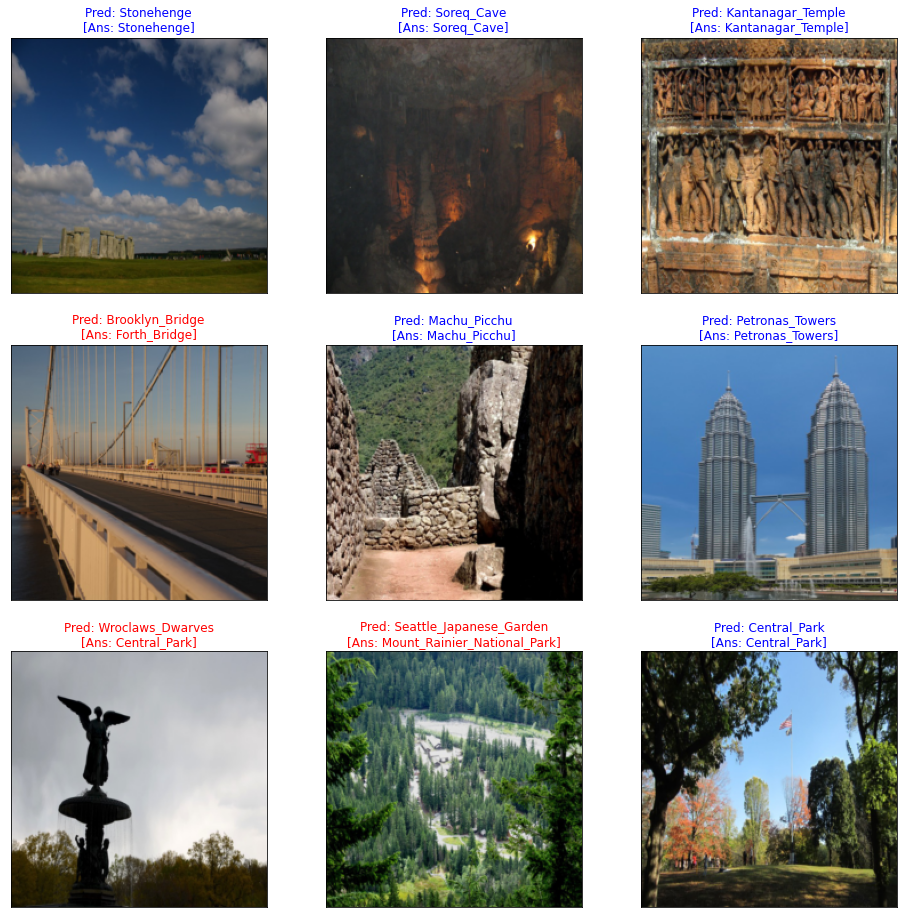

In [131]:
# obtain one batch of test images
try:
    images, labels = dataiter.next()
except NameError:
    dataiter = iter(testloader)
    images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output = model_transfer(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda \
                                         else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(16, 16))
for idx in range(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx], (1, 2, 0)))
    ax.set_title("Pred: %5s\n[Ans: %5s]" % (num2class[preds[idx]],
                                            num2class[labels[idx].item()]),
                  color=("blue" if preds[idx]==labels[idx].item() else "red"))

---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.


### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [134]:
def predict_landmarks(img_path, k):
    ## returns the names of the top k landmarks predicted by the 
    ## learning-transfered CNN, given a single raw undistorted image

    def topk(x, k):
        # input x is the output vector for a single image as a 1D np.array
        x = list(x.flatten())
        top = []
        while len(x) >= k and len(top) < k:
            top.append(np.argmax(x))
            # set value at the last index to -inf so won't be chosen again
            x[top[-1]] = -np.inf
        return top

    img = plt.imread(img_path)
    img = test_transforms(Image.fromarray(img))
    scores = model_transfer(img.reshape(1,3,224,224).cuda())
    scores = scores.cpu().detach().numpy()
    return [num2class[t] for t in topk(x=scores[0], k=k)]

# test on a sample image
top3 = predict_landmarks('test images/golden gate.jpg', 3)
print(top3)

['Golden_Gate_Bridge', 'Brooklyn_Bridge', 'Forth_Bridge']


### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

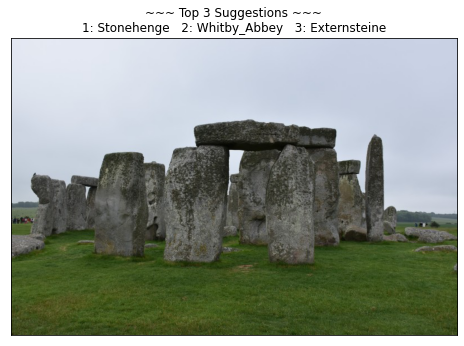

In [135]:
def suggest_locations(img_path):
    # get landmark predictions
    suggestions = predict_landmarks(img_path, 3)
    # display image with suggestions
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    ax.set_title("~~~ Top 3 Suggestions ~~~\n1: %5s   2: %5s   3: %5s" % (suggestions[0],
                                                                          suggestions[1],
                                                                          suggestions[2]))
    ax.imshow(plt.imread(img_path))
    return suggestions
    
# test on a sample image
suggestions = suggest_locations('test images/stonehenge.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.  Feel free to use as many code cells as needed.


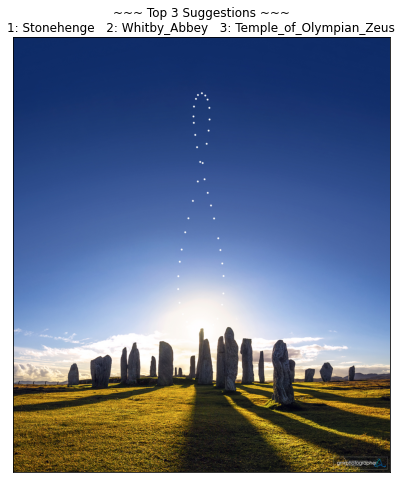

In [136]:
suggestions = suggest_locations('test images/standing stones.jpg')

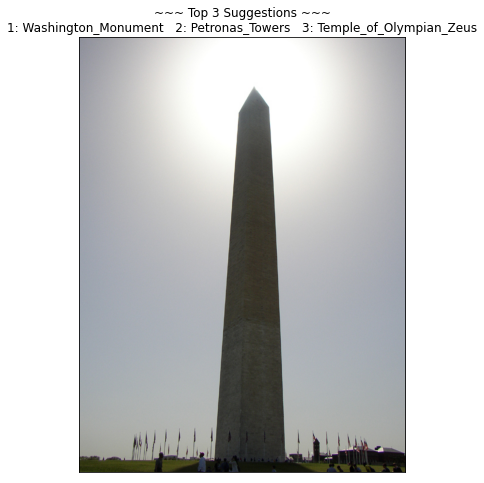

In [137]:
suggestions = suggest_locations('test images/washington monument.jpg')

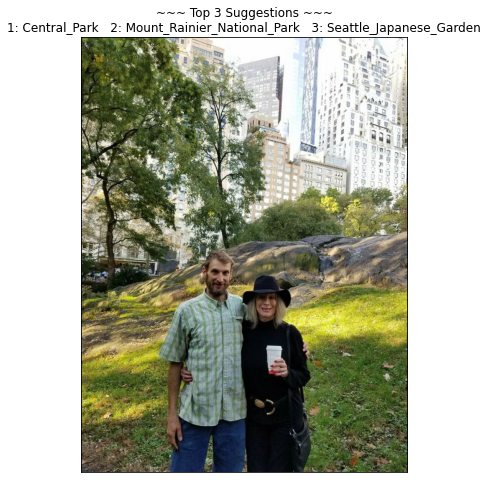

In [138]:
suggestions = suggest_locations('test images/central park.jpg')

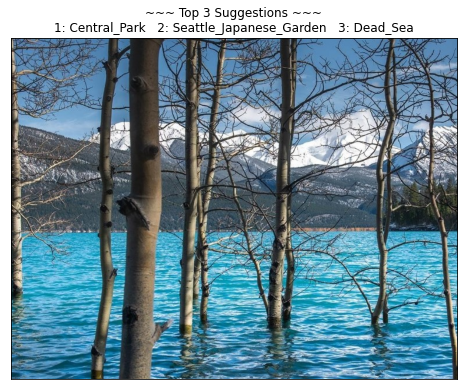

In [140]:
suggestions = suggest_locations('test images/unknown.jpg')

__Question 4:__ 

Is the output better than you expected? :) 
    Or worse? :(   
    Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
I thought the pretrained version did remarkably well.  The model-from-scratch was more difficult than expected to train past chance (2%).  Also surprising was that with just a few variations in training hyperparameters, I got two scratch_models to score in the 40-50% range on accuracy! That happened practically by accident and I am not sure which settings are to account for it.

Improvements:

* Data: better quality and more of it (and with optimized augmention, too). As implemented above: take the validation data from the test set, and train on the full training set of 4996 images.
* Use cv2 to accept non-jpeg image files, too
* As implemented above: instead of replacing the last pretrained layer, keep it with its pretrained params and tack another linear layer on at the very end w/ params 1000 --> 50 
* Use a different pretrained model (eg. ResNet type)
* Optimize variable learning-rate strategy
* rigorous optimization instead of "trial-and-error"
* "feed-forward" links?
* more untrained layers?
